In [1]:
import pandas as pd
from darts import TimeSeries
from darts.metrics.metrics import rmse
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, NBEATSModel, RandomForest, NHiTSModel

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cutoff_year = "2022"

In [3]:
data = pd.read_excel('../data/Actualandtarget_1401_10.xlsx')

In [4]:
sorted(data['Broker'].unique())

['Algrim, Phillip',
 'Altman, Cribb',
 'Andrew, Megan',
 'Angelle, Tiffany',
 'Ankenbrand, Kimarie',
 'Armstrong, Brooke',
 'Aziewicz, Karolina',
 'Barnes, Joe',
 'Barrett, David',
 'Bernet, Phoebe',
 'Berzina, David',
 'Biggs, Gregory',
 'Birnbach, Maggie',
 'Blount, Robert',
 'Bowles, Reese',
 'Breen, Daniel',
 'Briggs, Thomas',
 'Brower, Brandon',
 'Brown, Breanne',
 'Brownlee, John',
 'Burt, Harrison',
 'Carignan, Douglas',
 'Carrier, Angela',
 'Cash, Graham',
 'Cheek, Jason',
 'Coe, Clint',
 'Cole, Zane',
 'Comby, Kodie',
 'Cornwell, Andrew',
 'Cosby, Russell',
 'Coutu, Brandon',
 'Curry, Ashley',
 'Darrow, Terry',
 'Davidson, Rose',
 'Davis, Kade',
 'Dickerson, Taylor',
 'Dodson, Jason',
 'Doggett, Jon',
 'Eckert, Jeff',
 'Esquivel, James',
 'Ford, Elizabeth',
 'Forkner, Fiona',
 'Fortado, Elizabeth',
 'Franke, Trevor',
 'Franks, Robert',
 'Fuerstenberg, Gregg',
 'Galati, Vincent',
 'Gerber, Amy',
 'Glaze, Lawrence',
 'Gorney, Rachel',
 'Graham, Mason',
 'Griffin, Douglas',
 'Gri

In [5]:
data.columns

Index(['ProfId', 'Broker', 'FiscalYear', 'Actuals', 'BrokerTarget'], dtype='object')

In [6]:
data_sub = data[['Broker', 'FiscalYear', 'Actuals']]

In [7]:
data_sub_stack = data_sub.stack()

In [8]:
pivot_table =  pd.pivot_table(data_sub, values='Actuals', index='FiscalYear', columns='Broker')

In [9]:
transpose_pivot = pivot_table.transpose()

In [10]:
count_data = []

for year in transpose_pivot.columns:

    transpose_pivot_subset = transpose_pivot[[x for x in transpose_pivot.columns if x <= year]] 

    count = len(transpose_pivot_subset.dropna())

    count_data.append(count)

In [11]:
transpose_pivot.columns[:]

Index([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype='int64', name='FiscalYear')

In [12]:
count_data_dict = {'year': transpose_pivot.columns, 'count': count_data}

In [13]:
count_data_df  = pd.DataFrame(count_data_dict)

In [14]:
count_data_df

,year,count
0,2014,47
1,2015,45
2,2016,41
3,2017,41
4,2018,41
5,2019,38
6,2020,38
7,2021,37
8,2022,37
9,2023,33


In [15]:
import seaborn as sns

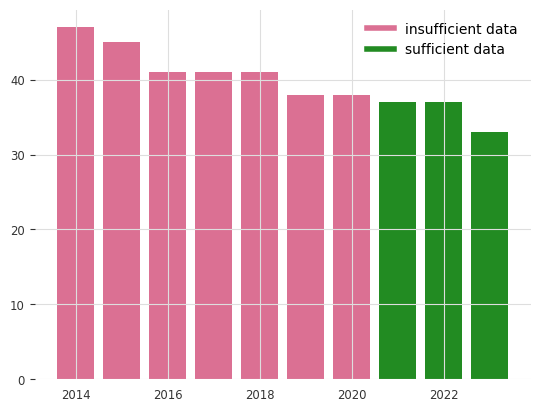

In [16]:
import matplotlib.pyplot as plt
color = ['lightblue', 'blue', 'purple', 'red', 'black']

color = []

for year in count_data_df['year']:
    
    if year <= 2020:
        color.append('palevioletred')
    else:
        color.append('forestgreen')


# Create bars
fig, ax = plt.subplots()
ax.bar(count_data_df['year'], count_data_df['count'],
       color=color,
       linewidth=1)
# Create custom legend
legend_labels = {'palevioletred': 'insufficient data', 'forestgreen': 'sufficient data'}
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_labels.keys()]
labels = [legend_labels[color] for color in legend_labels.keys()]
ax.legend(handles, labels)
# Show graph
plt.show()

In [17]:
transpose_pivot_subset = transpose_pivot[[x for x in transpose_pivot.columns if x < 2021]] 

In [18]:
transpose_pivot_subset.dropna(inplace=True)
brokers = transpose_pivot_subset.reset_index()['Broker']

/tmp/ipykernel_1895/607667974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transpose_pivot_subset.dropna(inplace=True)


### Brokers Target Data

In [19]:
full_data = pd.read_excel('../data/Actualandtarget_1401_10.xlsx')

In [20]:
filtered_data = full_data[full_data['Broker'].isin(brokers)]

In [21]:
filtered_data

,ProfId,Broker,FiscalYear,Actuals,BrokerTarget
0,16507,"Weatherby, Samuel",2014,637791.99,500000.0
1,16507,"Weatherby, Samuel",2015,1043269.72,600000.0
2,16507,"Weatherby, Samuel",2016,576363.95,1633334.0
3,16507,"Weatherby, Samuel",2017,683077.75,600000.0
4,16507,"Weatherby, Samuel",2018,1662274.72,850000.0
...,...,...,...,...,...
446,192406,"Sheehy, Ahnie",2019,500000.00,NaN
447,192406,"Sheehy, Ahnie",2020,303459.66,NaN
448,192406,"Sheehy, Ahnie",2021,217530.65,500000.0
449,192406,"Sheehy, Ahnie",2022,488972.28,900000.0


In [22]:
filtered_data_pivot_table = pd.pivot(filtered_data, index = 'FiscalYear', columns='Broker', values='BrokerTarget').transpose().reset_index()

In [23]:
filtered_data_pivot_table.to_excel('../data/filtered_broker_target.xlsx',index=False)

In [24]:
null_count = filtered_data_pivot_table.isna().sum()
null_count = null_count.reset_index()
null_count = null_count.rename(columns={0:'Count'})

In [25]:
null_count

,FiscalYear,Count
0,Broker,0
1,2014,5
2,2015,0
3,2016,0
4,2017,0
5,2018,1
6,2019,37
7,2020,19
8,2021,32
9,2022,22


In [26]:
# plt.bar(x=null_count['FiscalYear'], height=null_count['Count'], color = 'darkgreen')
# plt.title('Number of null values in the BrokerTarget')
# plt.show()

([<matplotlib.patches.Wedge at 0x71d3a1d859f0>,
 [Text(1.1, 0.0, 'Broker'),
  Text(1.0922206726774804, 0.13059097279656146, '2014'),
  Text(1.0689927233164507, 0.2593348366426671, '2015'),
  Text(1.0689927233164507, 0.2593348366426671, '2016'),
  Text(1.0689927233164507, 0.2593348366426671, '2017'),
  Text(1.062518406696673, 0.28470095790278555, '2018'),
  Text(0.43301522850248725, 1.0111863388539912, '2019'),
  Text(-0.8805953678222178, 0.6592054294148776, '2020'),
  Text(-0.9253788759906101, -0.5947049149539251, '2021'),
  Text(0.309905870917812, -1.0554422538304369, '2022'),
  Text(1.0212047599553087, -0.4088286172036159, '2023')])

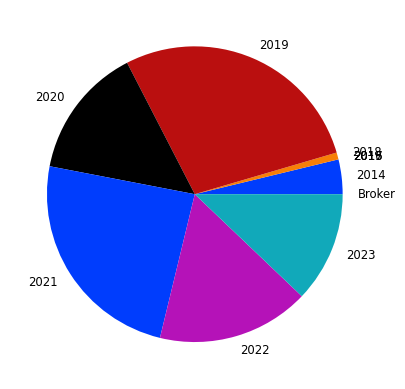

In [27]:
plt.pie(null_count['Count'], labels=null_count['FiscalYear'])

In [28]:
pd.Timestamp(cutoff_year)

Timestamp('2022-01-01 00:00:00')

In [29]:
transpose = pivot_table.transpose()

In [30]:
transpose.reset_index(inplace=True)

In [31]:
transpose

FiscalYear,Broker,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"Algrim, Phillip",54327.00,85560.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Altman, Cribb",NaN,NaN,NaN,NaN,NaN,NaN,NaN,598664.08,1688739.14,1365978.45
2,"Andrew, Megan",NaN,NaN,NaN,NaN,NaN,24413.30,161728.98,517348.12,480929.23,0.02
3,"Angelle, Tiffany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159242.61,500000.00
4,"Ankenbrand, Kimarie",448814.94,886525.48,513090.78,1293516.03,1022890.53,67984.06,33.90,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149,"Wright, Chris",NaN,NaN,NaN,NaN,NaN,NaN,NaN,137344.44,943481.20,818594.54
150,"Wyse, Henry",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,293149.93
151,"Yoakam, Coler",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
152,"garner, michael",NaN,NaN,NaN,NaN,NaN,NaN,213333.25,1059929.20,1464745.68,-0.01


In [32]:
clean_data = pivot_table.dropna(axis=1)

In [33]:
len(clean_data.columns)

33

In [34]:
len(pivot_table.columns)

154

In [35]:
clean_data.reset_index(inplace=True)

In [36]:
clean_data["FiscalYear"] = pd.to_datetime(clean_data["FiscalYear"], format="%Y")

/tmp/ipykernel_1895/4100552494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data["FiscalYear"] = pd.to_datetime(clean_data["FiscalYear"], format="%Y")


In [37]:
clean_data

Broker,FiscalYear,"Armstrong, Brooke","Breen, Daniel","Cosby, Russell","Curry, Ashley","Darrow, Terry","Eckert, Jeff","Esquivel, James","Forkner, Fiona","Haggar, James",...,"Selner, Bradley","Sheehy, Ahnie","Shipley, Christopher","Smith, Jubal","Stout, Christopher","Taguwa, Andrew","Toon, Larry","Weatherby, Samuel","Whitman, Paul","Wood, Alan"
0,2014-01-01,1380583.55,171398.16,770342.33,88839.39,1003383.83,750000.05,750000.01,384698.30,301113.55,...,3188933.63,151.72,356160.84,1771504.76,102575.75,901100.59,2259899.50,637791.99,1562838.05,856670.45
1,2015-01-01,631544.09,2194829.40,463416.90,335981.55,815760.82,997785.67,997785.62,998910.44,525300.89,...,2209823.93,142877.89,633904.48,7359378.40,250876.09,1011467.41,983978.26,1043269.72,1997295.13,786498.94
2,2016-01-01,1125976.16,1492879.42,1897362.90,401767.00,360931.29,995381.26,990905.52,1301178.85,641300.49,...,2076925.86,218536.00,808734.66,2113433.76,439799.56,714371.11,68855.76,576363.95,1207541.71,608604.08
3,2017-01-01,1526556.11,2425068.14,216952.35,267907.45,588227.17,812467.24,807640.25,665690.49,533198.91,...,2135517.42,333502.62,1325188.67,1495679.59,439281.72,998930.30,7801514.26,683077.75,363890.00,626262.49
4,2018-01-01,1786851.61,1557403.06,1035997.29,506123.66,429284.82,939797.56,939452.24,701267.31,540839.62,...,837927.59,394708.13,1221506.39,1477429.31,439691.67,1171395.37,543049.64,1662274.72,947842.79,433940.03
5,2019-01-01,2927638.63,1966813.19,2630950.86,393480.17,500000.00,610360.97,610355.66,589002.22,776827.65,...,3435213.05,500000.00,875584.42,9027557.98,837256.10,500000.00,563242.34,542493.41,798450.78,676387.34
6,2020-01-01,2774229.05,694513.79,85726.02,226290.45,69027.42,555576.34,555576.49,585002.05,765932.58,...,5020462.00,303459.66,1030727.50,1858116.40,729262.65,826222.42,204838.14,128476.25,1288304.98,92353.73
7,2021-01-01,1521039.35,1176575.40,1734397.73,529705.03,890021.64,1162108.21,1121160.16,334546.52,293815.62,...,3908492.32,217530.65,1382872.15,4769175.02,888623.37,650988.56,3920452.28,513034.18,1154146.70,273606.92
8,2022-01-01,138760.99,243170.51,262885.16,557611.48,240795.18,1101099.99,1071926.24,750000.00,1310808.71,...,4545074.40,488972.28,3319633.14,584342.95,900358.85,1277070.87,26433.64,559862.94,363262.31,500000.00
9,2023-01-01,-10737.07,427007.70,15142.76,592223.29,9041.67,986421.71,846948.54,1319272.27,2250000.00,...,2703434.77,126778.85,1530226.11,758521.60,1331616.06,1417720.02,26137.89,1128375.68,334568.10,180236.10


In [38]:
series = TimeSeries.from_dataframe(clean_data, time_col="FiscalYear")

In [45]:
name1 = series['Armstrong, Brooke']


In [51]:
name_df = name1.pd_dataframe()

In [59]:
import pandas as pd

# Sample DataFrame
data = {
    'Predicted Target ($)': [572929.3398, 647138.1216],
    'lower': [-56270.6602, 17938.1216],
    'upper': [1202129.3398, 1276338.1216]
}
index = pd.to_datetime(['2024-01-01', '2025-01-01'])
df = pd.DataFrame(data, index=index)

# Function to apply color to the 'Predicted Target ($)' column
def color_predicted(val):
    return 'color: red'

# Function to apply color to the 'lower' and 'upper' columns
def color_lower_upper(val):
    return 'color: green'

# Applying styles to the DataFrame
styled_df = df.style.applymap(color_predicted, subset=['Predicted Target ($)'])\
                    .applymap(color_lower_upper, subset=['lower', 'upper'])\
                    .set_table_styles([
                        {'selector': 'th', 'props': [('background-color', '#2C2E3E')]}
                    ])

# Display the styled DataFrame
styled_df


/tmp/ipykernel_1895/4088407099.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_predicted, subset=['Predicted Target ($)'])\


,Predicted Target ($),lower,upper
2024-01-01 00:00:00,572929.339800,-56270.660200,1202129.339800
2025-01-01 00:00:00,647138.121600,17938.121600,1276338.121600


In [ ]:
def style_negative(v, props=''):
    return props if v < 0 else None
s2 = df2.style.map(style_negative, props='color:red;')\
              .map(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)
s2

In [54]:
name_df[['upper','lower']] = [name_df['Armstrong, Brooke'].values, name_df['Armstrong, Brooke'].values]

ValueError: Columns must be same length as key

In [40]:
name2 = name1 - 10000
name3 = name1 + 10000

In [41]:
name2 = name2.with_columns_renamed('Armstrong, Brooke', 'lower')
name3 = name3.with_columns_renamed('Armstrong, Brooke', 'upper')

In [42]:
temp = name1.stack(name2.stack(name3))

In [43]:
temp.pd_dataframe()

component,"Armstrong, Brooke",lower,upper
FiscalYear,,,
2014-01-01,1380583.55,1370583.55,1390583.55
2015-01-01,631544.09,621544.09,641544.09
2016-01-01,1125976.16,1115976.16,1135976.16
2017-01-01,1526556.11,1516556.11,1536556.11
2018-01-01,1786851.61,1776851.61,1796851.61
2019-01-01,2927638.63,2917638.63,2937638.63
2020-01-01,2774229.05,2764229.05,2784229.05
2021-01-01,1521039.35,1511039.35,1531039.35
2022-01-01,138760.99,128760.99,148760.99


In [44]:
temp['ci'] = temp[['lower', 'upper']].apply(lambda row: (row['lower'], row['upper']), axis=1)


AttributeError: 'TimeSeries' object has no attribute 'apply'

In [ ]:
temp

component,"Armstrong, Brooke",lower,upper,ci
FiscalYear,,,,
2014-01-01,1380583.55,1370583.55,1390583.55,"(1370583.55, 1390583.55)"
2015-01-01,631544.09,621544.09,641544.09,"(621544.09, 641544.09)"
2016-01-01,1125976.16,1115976.16,1135976.16,"(1115976.16, 1135976.16)"
2017-01-01,1526556.11,1516556.11,1536556.11,"(1516556.11, 1536556.11)"
2018-01-01,1786851.61,1776851.61,1796851.61,"(1776851.61, 1796851.61)"
2019-01-01,2927638.63,2917638.63,2937638.63,"(2917638.63, 2937638.63)"
2020-01-01,2774229.05,2764229.05,2784229.05,"(2764229.05, 2784229.05)"
2021-01-01,1521039.35,1511039.35,1531039.35,"(1511039.35, 1531039.35)"
2022-01-01,138760.99,128760.99,148760.99,"(128760.98999999999, 148760.99)"


<Axes: xlabel='FiscalYear'>

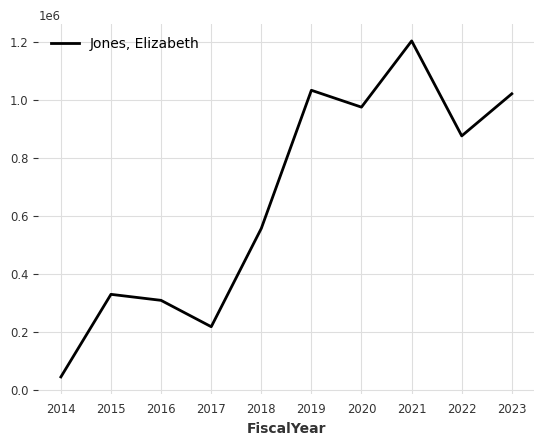

In [ ]:
import random

name = random.choice(clean_data.columns[1:])
series[name].plot()

In [ ]:
train_series, val_series = series.split_before(pd.Timestamp(cutoff_year))

In [ ]:
scaler = Scaler()
training_scaled = scaler.fit_transform(train_series[name])
validation_scaled = scaler.transform(val_series[name])

In [ ]:
from darts.models import NaiveMovingAverage

In [ ]:
moving_average = NaiveMovingAverage(input_chunk_length=3)
moving_average.fit(training_scaled[name])
prediction = moving_average.predict(4)

<Axes: xlabel='FiscalYear'>

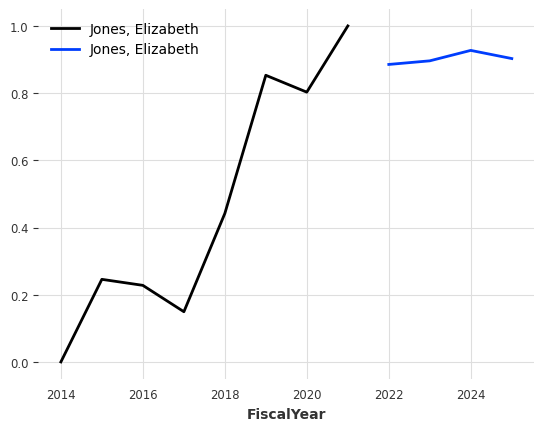

In [ ]:
training_scaled[name].plot()
prediction.plot()

In [ ]:
rmse(validation_scaled[name], prediction)

0.12465067457372678

In [ ]:
from darts.utils.utils import ModelMode

In [ ]:
es = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=None)
es.fit(training_scaled[name])
prediction = es.predict(2)


In [ ]:
validation_scaled[name]

<TimeSeries (DataArray) (FiscalYear: 2, component: 1, sample: 1)> Size: 16B
array([[[0.71735436]],

       [[0.84267568]]])
Coordinates:
  * FiscalYear  (FiscalYear) datetime64[ns] 16B 2022-01-01 2023-01-01
  * component   (component) object 8B 'Jones, Elizabeth'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
prediction

<TimeSeries (DataArray) (FiscalYear: 2, component: 1, sample: 1)> Size: 16B
array([[[0.69857234]],

       [[0.73721891]]])
Coordinates:
  * FiscalYear  (FiscalYear) datetime64[ns] 16B 2022-01-01 2023-01-01
  * component   (component) object 8B 'Haggar, James'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
scaler.inverse_transform(prediction)

<TimeSeries (DataArray) (FiscalYear: 2, component: 1, sample: 1)> Size: 16B
array([[[631234.46632757]],

       [[649901.22355446]]])
Coordinates:
  * FiscalYear  (FiscalYear) datetime64[ns] 16B 2022-01-01 2023-01-01
  * component   (component) object 8B 'Haggar, James'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
scaler.inverse_transform(validation_scaled)

<TimeSeries (DataArray) (FiscalYear: 2, component: 1, sample: 1)> Size: 16B
array([[[1310808.71]],

       [[2250000.  ]]])
Coordinates:
  * FiscalYear  (FiscalYear) datetime64[ns] 16B 2022-01-01 2023-01-01
  * component   (component) object 8B 'Haggar, James'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='FiscalYear'>

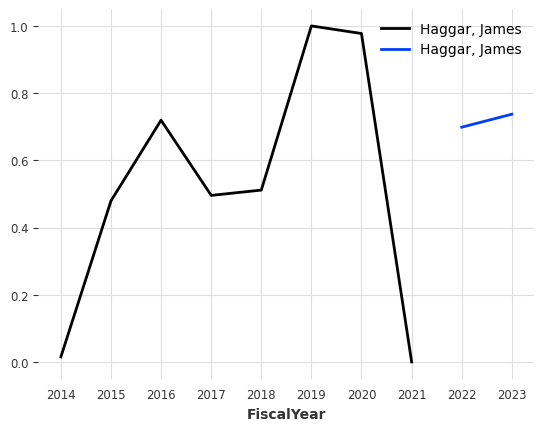

In [ ]:
training_scaled[name].plot()
prediction.plot()

In [ ]:
rmse(validation_scaled[name], prediction)

2.5449786676881385

In [ ]:
rf = RandomForest(lags=4, n_estimators=10)
rf.fit(training_scaled[name])
prediction = rf.predict(2024 - int(cutoff_year))
rf_score = rmse(validation_scaled[name], prediction)
rf_score

2.552313322319344

def get_score(name, training_scaled, validation_scaled):

    score = {}

    # baseline 
    moving_average = NaiveMovingAverage(input_chunk_length=3)
    moving_average.fit(training_scaled[name])
    prediction = moving_average.predict(2024 - int(cutoff_year))

    moving_average_score = rmse(validation_scaled[name], prediction)
    score["MovingAverage"] = moving_average_score

    # statistical 
    es = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=None)
    es.fit(training_scaled[name])
    prediction = es.predict(2024 - int(cutoff_year))


    es_score = rmse(validation_scaled[name], prediction)
    score["ExponentialSmoothing"] = es_score


    # ml
    rf = RandomForest(lags=4, n_estimators=10)
    rf.fit(training_scaled[name])
    prediction = rf.predict(2024 - int(cutoff_year))
    rf_score = rmse(validation_scaled[name], prediction)
    
    score["RandomForest"] = rf_score

    # dl

    nhits = NHiTSModel(
    input_chunk_length=3,
    output_chunk_length=4,
    num_blocks=2,
    n_epochs=5,
)
    nhits.fit(training_scaled[name])
    prediction = nhits.predict(2024 - int(cutoff_year))
    nhits_score = rmse(validation_scaled[name], prediction)
    score["NHiTS"] = nhits_score


    return score
    



In [ ]:
from darts.metrics.metrics import mape

In [ ]:
def get_mape_score(training, validation):

    score = {}
    scaler = Scaler()
    training_scaled = scaler.fit_transform(training)
    validation_scaled = scaler.transform(validation)

    # baseline 
    moving_average = NaiveMovingAverage(input_chunk_length=3)
    moving_average.fit(training_scaled)
    prediction_ma = moving_average.predict(2024 - int(cutoff_year))

    
    prediction_inverse_scale = scaler.inverse_transform(prediction_ma)
    moving_average_score = mape(validation, prediction_inverse_scale)
    score["MovingAverage"] = moving_average_score

    # statistical 
    es = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=None)
    es.fit(training_scaled[name])
    prediction_es = es.predict(2024 - int(cutoff_year))


    prediction_inverse_scale_es = scaler.inverse_transform(prediction_es)
    es_score = mape(validation, prediction_inverse_scale_es)
    score["ExponentialSmoothing"] = es_score


    # ml
    rf = RandomForest(lags=4, n_estimators=10)
    rf.fit(training_scaled[name])
    prediction_rf = rf.predict(2024 - int(cutoff_year))

    prediction_inverse_scale_rf = scaler.inverse_transform(prediction_rf)
    rf_score = mape(validation, prediction_inverse_scale_rf)
    score["RandomForest"] = rf_score

    # dl

    nhits = NHiTSModel(
    input_chunk_length=3,
    output_chunk_length=4,
    num_blocks=2,
    n_epochs=5,
)
    nhits.fit(training_scaled[name])
    prediction_nhits = nhits.predict(2024 - int(cutoff_year))

    prediction_inverse_scale_nhits = scaler.inverse_transform(prediction_nhits)
    nhits_score = mape(validation, prediction_inverse_scale_nhits)
    score["NHiTS"] = nhits_score

    


    
    training.plot()
    validation.plot(label='Validate')
    
    prediction_inverse_scale_es.plot(label='es')
    prediction_inverse_scale_rf.plot(label='rf')
    prediction_inverse_scale_nhits.plot(label='nhits')

    return score

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 21.64it/s, train_loss=0.211] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s, train_loss=0.211]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.83it/s] 


{'MovingAverage': 14.157280430617476,
 'ExponentialSmoothing': 48.71800616359019,
 'RandomForest': 14.957390420333082,
 'NHiTS': 69.90074214891096}

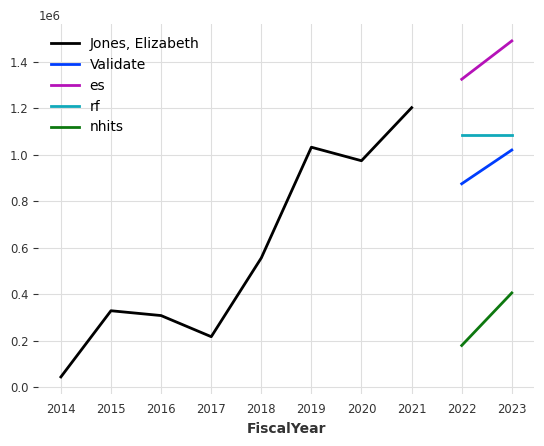

In [ ]:
get_mape_score(train_series[name], val_series[name])

In [ ]:
scores

{'MovingAverage': 2.680774222710387,
 'ExponentialSmoothing': 2.5449786676881385,
 'RandomForest': 2.552313322319344,
 'NHiTS': 1.648369800408696}

In [ ]:
moving_average_list = []
exponential_smoothing_list = []
rf_list = []
nhits_list = []
for name in clean_data.columns[1:]:

    scaler = Scaler()
    training_scaled = scaler.fit_transform(train_series[name])
    validation_scaled = scaler.transform(val_series[name])
    scores = get_score(name, training_scaled, validation_scaled)

    moving_average_list.append(scores['MovingAverage'])
    exponential_smoothing_list.append(scores['ExponentialSmoothing'])
    rf_list.append(scores['RandomForest'])
    nhits_list.append(scores['NHiTS'])
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s, train_loss=0.235] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, train_loss=0.235]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.43it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 37.35it/s, train_loss=0.0784]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s, train_loss=0.0784]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.83it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s, train_loss=0.0647]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s, train_loss=0.0647]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.24it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s, train_loss=0.0674]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.37it/s, train_loss=0.0674]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.68it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.54it/s, train_loss=0.162]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.34it/s, train_loss=0.162]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.60it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.11it/s, train_loss=0.101]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s, train_loss=0.101]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.98it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s, train_loss=0.124]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s, train_loss=0.124]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss=1.050]         

Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s, train_loss=0.124]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.54it/s, train_loss=0.124]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.04it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.06it/s, train_loss=0.0411]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s, train_loss=0.0411]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.64it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 37.79it/s, train_loss=0.145]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.70it/s, train_loss=0.145]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.54it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s, train_loss=0.252]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s, train_loss=0.252]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.10it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s, train_loss=0.231] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s, train_loss=0.231]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.67it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s, train_loss=0.0322]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s, train_loss=0.0322]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.52it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 25.28it/s, train_loss=0.310] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s, train_loss=0.310]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.30it/s] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.21it/s, train_loss=0.211] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s, train_loss=0.211]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s, train_loss=0.181]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s, train_loss=0.181]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s, train_loss=0.216] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.97it/s, train_loss=0.216]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.93it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s, train_loss=0.219]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.95it/s, train_loss=0.219]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.84it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.39it/s, train_loss=0.279] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.63it/s, train_loss=0.279]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.98it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.94it/s, train_loss=0.0512]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.58it/s, train_loss=0.0512]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.25it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s, train_loss=0.0982]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s, train_loss=0.0982]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.10it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, train_loss=0.286]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.53it/s, train_loss=0.286]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.80it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 37.92it/s, train_loss=0.135]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s, train_loss=0.135]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.08it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.38it/s, train_loss=0.162]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s, train_loss=0.162]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.94it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.50it/s, train_loss=0.047]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s, train_loss=0.047]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.43it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s, train_loss=0.0844]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.32it/s, train_loss=0.0844]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.65it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, train_loss=0.0407]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s, train_loss=0.0407]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s, train_loss=0.170] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.19it/s, train_loss=0.170]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.58it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s, train_loss=0.139]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 36.67it/s, train_loss=0.139]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.49it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.42it/s, train_loss=0.0813]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 32.82it/s, train_loss=0.0813]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.59it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 34.02it/s, train_loss=0.156]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 31.51it/s, train_loss=0.156]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.94it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 26.42it/s, train_loss=0.101]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, train_loss=0.101]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.67it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
1.5 K     Non-trainable params
1.6 M     Total params
6.423     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 35.67it/s, train_loss=0.112]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.43it/s, train_loss=0.112]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.93it/s]


In [ ]:
sum(moving_average_list)

19.517750220208523

In [ ]:
print(f"the aveage score of moving average is {round(sum(moving_average_list)/len(moving_average_list),3)}")
print(f"the aveage score of exponential Smoothing is {round(sum(exponential_smoothing_list)/len(exponential_smoothing_list),3)}")
print(f"the aveage score of random forest is {round(sum(rf_list)/len(rf_list),3)}")
print(f"the aveage score of nhits is {round(sum(nhits_list)/len(nhits_list),3)}")


the aveage score of moving average is 0.591
the aveage score of exponential Smoothing is 0.572
the aveage score of random forest is 0.593
the aveage score of nhits is 0.74
